In [1]:
import numpy as np
from scipy import special
from geometries import cubic_domain
from operators import fonction_spaces, solve_, solve_WCAWE, integral_mesure, z_f_matrices_b1p_withDiff, z_f_matrices_b2p_withDiff, basis_N_WCAWE, Zn_Fn_matrices, reduced_solution
from postprocess import relative_errZ,import_FOM_result
from dolfinx.fem import (form, Function, FunctionSpace, petsc)
import petsc4py
from petsc4py import PETSc
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


In [2]:
N = 6

# Créer la matrice Q
Q = PETSc.Mat().create()
Q.setSizes((N, N))
Q.setType("seqdense")
Q.setFromOptions()
Q.setUp()
Q.setValue(2, 3, 2.0 + 1.j)
Q.assemble()
print(Q.getType())

# Obtenir le vecteur associé à la colonne 3
vec_Q = Q.getColumnVector(3)

# Obtenir le vecteur conjugué
vec_Q_conjugue = np.conj(vec_Q)
print('here')
print(vec_Q_conjugue)

Q.setValues([2,4,5], [4,5], [[10, 11],[20, 21], [31,30]], PETSc.InsertMode.INSERT_VALUES)
Q.assemble()
print(Q.view())


def sub_matrix(Q, start, end):
    row_is = PETSc.IS().createStride(end - start, first=start, step=1)
    col_is = PETSc.IS().createStride(end - start, first=start, step=1)
    submatrix = Q.createSubMatrix(row_is, col_is)

    row_is.destroy()
    col_is.destroy()

    submatrix = submatrix.getValues([i for i in range(end - start)], [i for i in range(end - start)])
    return submatrix

sub_ = sub_matrix(Q, 5, 6)
print(sub_)


def sub_matrix(Q, start, end):
    row_is = PETSc.IS().createStride(end - start , first=start, step=1)
    col_is = PETSc.IS().createStride(end - start , first=start, step=1)
    submatrix = Q.createSubMatrix(row_is, col_is)

    row_is.destroy()
    col_is.destroy()
    submatrix = submatrix.getValues([i for i in range(end - start)], [i for i in range(end - start)])
    return submatrix

sub_ = sub_matrix(Q, 5, 6)
print(sub_)

seqdense
here
[0.-0.j 0.-0.j 2.-1.j 0.-0.j 0.-0.j 0.-0.j]
Mat Object: 1 MPI process
  type: seqdense
0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 
0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 
0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 2.0000000000000000e+00 + 1.0000000000000000e+00i 1.0000000000000000e+01 + 0.0000000000000000e+00i 1.1000000000000000e+01 + 0.0000000000000000e+00i 
0.000000000000

In [27]:
print(Q.getSizes())
row_is = PETSc.IS().createStride(Q.getSize()[0], first=0, step=1)
col_is = PETSc.IS().createStride(3, first=3, step=1)

Vn_i = Q.createSubMatrix(row_is, col_is)
Vn_i.view()
print(Vn_i.getSize())

vec1 = Vn_i.getColumnVector(1)
vec2 = Vn_i.getColumnVector(2)
print(vec1.dot(vec2))
print(vec1.view())
vec1 = 2 * vec1
print(vec1.view())

((3, 3), (3, 3))
Mat Object: 1 MPI process
  type: seqdense
0.0000000000000000e+00 + 2.4209216646221081e-322i 6.9533040744481032e-310 + 2.4209216646221081e-322i 6.9533040329149688e-310 + 4.0019317313140970e-322i 
2.6498905745461856e+180 + 1.0638921494845551e+228i 2.6498905745461856e+180 + 2.6498905745466546e+180i 1.0000000000000000e+00 + -0.0000000000000000e+00i 
6.3490892977163971e+151 + 6.9533040336795354e-310i 2.1553016122294080e-307 + 6.9533040634474352e-310i 2.0000000000000000e+00 + -0.0000000000000000e+00i 
(3, 3)
(2.6498905745461856e+180+2.6498905745466546e+180j)
Vec Object: 1 MPI process
  type: seq
6.9533e-310 + 2.42092e-322 i
2.64989e+180 + 2.64989e+180 i
2.1553e-307 + 6.9533e-310 i
None
Vec Object: 1 MPI process
  type: seq
1.39066e-309 + 4.84184e-322 i
5.29978e+180 + 5.29978e+180 i
4.3106e-307 + 1.39066e-309 i
None


In [4]:
import numpy as np

def modified_gram_schmidt(Vn, vn):
    # Vérifier que la base Vn est non vide
    if len(Vn) == 0:
        raise ValueError("La base Vn ne doit pas être vide.")

    # Convertir la base en une matrice numpy
    Vn_matrix = np.array(Vn)

    # Orthonormalisation du nouveau vecteur vn
    for v in Vn_matrix:
        vn -= np.dot(vn, v) * v

    # Normalisation du vecteur vn
    vn = vn/np.linalg.norm(vn)

    return vn

# Exemple d'utilisation :
# Supposons que Vn est une liste de vecteurs et vn est le nouveau vecteur à ajouter
Vn = [np.array([1, 0, 0]), np.array([0, 1, 0])]
vn = np.array([1, 1, 1])

# Orthonormaliser vn par rapport à la base Vn
vn_orthonormalise = modified_gram_schmidt(Vn, vn)

# Afficher le résultat
print("vn orthonormalisé:", vn_orthonormalise)


vn orthonormalisé: [0. 0. 1.]


In [5]:
import numpy as np

def modified_gram_schmidt_complex(Vn, vn):
    # Vérifier que la base Vn est non vide
    if len(Vn) == 0:
        raise ValueError("La base Vn ne doit pas être vide.")

    # Convertir la base en une matrice numpy de complexes
    Vn_matrix = np.array(Vn, dtype=np.complex128)

    # Orthonormalisation du nouveau vecteur vn
    for v in Vn_matrix:
        vn -= np.vdot(vn, v) * v

    # Normalisation du vecteur vn
    vn = vn/np.linalg.norm(vn)

    return vn

# Exemple d'utilisation :
# Supposons que Vn est une liste de vecteurs complexes et vn est le nouveau vecteur à ajouter
Vn = [np.array([1 + 2j, 0 + 1j]), np.array([2 + 1j, 1 - 1j])]
vn = np.array([1 - 1j, 1 + 1j])

# Orthonormaliser vn par rapport à la base Vn
vn_orthonormalise = modified_gram_schmidt_complex(Vn, vn)
Vn.append(vn_orthonormalise)

# Afficher le résultat
print("vn orthonormalisé:", vn_orthonormalise)
print(np.linalg.norm(vn_orthonormalise))
print(np.vdot(Vn[1], np.conj(Vn[1])))
i=0
for v in Vn:
    Vn[i] = v/np.linalg.norm(v)
    i = i +1

print(np.dot(Vn[1], Vn[1]))
print(np.linalg.norm(Vn[1]))

vn orthonormalisé: [-0.21559592-0.86238368j -0.44915817+0.08983163j]
0.9999999999999998
(3-2j)
(0.42857142857142844+0.28571428571428564j)
0.9999999999999999


In [6]:
def check_ortho(Vn):
    N = Vn.getSize()[1]
    for i in range(N-1):
        vec1 = Vn.getColumnVector(i)
        vec2 = Vn.getColumnVector(i+1)
        result = vec1.dot(vec2)
        print("vec"+str(i)+" . vec"+str(i+1)+" = "+str(result))

In [7]:

N = 3

# Créer la matrice Q
Q = PETSc.Mat().create()
Q.setSizes((N, N))
Q.setType("seqdense")
Q.setFromOptions()
Q.setUp()
Q.setValues([i for i in range(N)], [0,1], [[1, 1+1j], [1j, 1-1j], [0, -2]], PETSc.InsertMode.INSERT_VALUES)
Q.assemble()
print(Q.view())
Vn = PETSc.Mat().create()
Vn.setSizes((N, 2))
Vn.setType("seqdense")
Vn.setFromOptions()
Vn.setUp()
Vn.setValues([i for i in range(N)], [0,1], [[1, 1+1j],[1j, 1-1j], [0, -2]], PETSc.InsertMode.INSERT_VALUES)
Vn.assemble()
Vn.view()
print("Test on the ortho of Vn")
check_ortho(Vn)
vec_1 = Q.getColumnVector(0)
vec_2 = Q.getColumnVector(1)
print(vec_1.getArray())
print('vec 2:')
print(vec_2.getArray())
#vec_2.conjugate()
print('vec 2 conj:')
print(vec_2.getArray())
result = vec_1.dot(vec_2)
print(result)


Mat Object: 1 MPI process
  type: seqdense
1.0000000000000000e+00 + 0.0000000000000000e+00i 1.0000000000000000e+00 + 1.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 
0.0000000000000000e+00 + 1.0000000000000000e+00i 1.0000000000000000e+00 + -1.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 
0.0000000000000000e+00 + 0.0000000000000000e+00i -2.0000000000000000e+00 + 0.0000000000000000e+00i 0.0000000000000000e+00 + 0.0000000000000000e+00i 
None
Mat Object: 1 MPI process
  type: seqdense
1.0000000000000000e+00 + 0.0000000000000000e+00i 1.0000000000000000e+00 + 1.0000000000000000e+00i 
0.0000000000000000e+00 + 1.0000000000000000e+00i 1.0000000000000000e+00 + -1.0000000000000000e+00i 
0.0000000000000000e+00 + 0.0000000000000000e+00i -2.0000000000000000e+00 + 0.0000000000000000e+00i 
Test on the ortho of Vn
vec0 . vec1 = 0j
[1.+0.j 0.+1.j 0.+0.j]
vec 2:
[ 1.+1.j  1.-1.j -2.+0.j]
vec 2 conj:
[ 1.+1.j  1.-1.j -2.+0.j]
0j


In [8]:
v = [1, 1j, 0]
w = [1+1j, 1-1j, -2]
print(np.dot(v,np.conj(w)))


0j


In [9]:
vec_1 = Q.getColumnVector(0)
vec_2 = Q.getColumnVector(1)
print(vec_1.getArray())
print(vec_2.getArray())

for i in range(vec_2.getSize()):
    vec_2.setValue(i, np.conj(vec_2.getValue(i)))

print(vec_2.getArray())

[1.+0.j 0.+1.j 0.+0.j]
[ 1.+1.j  1.-1.j -2.+0.j]
[ 1.-1.j  1.+1.j -2.-0.j]


In [10]:
print("gere")

gere


In [11]:
alpha = 8
beta = 2

P_q = np.identity(alpha - beta)
print(P_q)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [12]:
y = np.array([[2, 2], [2, 2]])
print(y)
print(y.size)
y = PETSc.Vec().createWithArray(y[0])
print(y.view())

[[2 2]
 [2 2]]
4
Vec Object: 1 MPI process
  type: seq
2.
2.
None


In [13]:
import numpy as np

# Créer une matrice 2D avec NumPy
matrice = np.array([[1, 2, 3], [4, 5, 6]])

# Obtenir les dimensions
dimensions = matrice.shape

# Afficher les dimensions
print("Nombre de lignes:", dimensions[0])
print("Nombre de colonnes:", dimensions[1])


Nombre de lignes: 2
Nombre de colonnes: 3


In [14]:
N = 3

# Créer la matrice Q
Q = PETSc.Mat().create()
Q.setSizes((N, N))
Q.setType("seqdense")
Q.setFromOptions()
Q.setUp()
Q.setValues([i for i in range(N)], [0,1,2], [[1, 2, 0],[1, -1, 1], [0, -2, 1]], PETSc.InsertMode.INSERT_VALUES)
Q.assemble()
print(Q.view())
Q = 2*Q
print(Q.view())

Mat Object: 1 MPI process
  type: seqdense
1.0000000000000000e+00 2.0000000000000000e+00 0.0000000000000000e+00 
1.0000000000000000e+00 -1.0000000000000000e+00 1.0000000000000000e+00 
0.0000000000000000e+00 -2.0000000000000000e+00 1.0000000000000000e+00 
None
Mat Object: 1 MPI process
  type: seqdense
2.0000000000000000e+00 4.0000000000000000e+00 0.0000000000000000e+00 
2.0000000000000000e+00 -2.0000000000000000e+00 2.0000000000000000e+00 
0.0000000000000000e+00 -4.0000000000000000e+00 2.0000000000000000e+00 
None


In [15]:
def print_something(something):
    print(something)

def print_something_else(something):
    print('here we are')

def help(fct):
    print('Here we are')
    fct('yes')

help(print_something)
help(print_something_else)

Here we are
yes
Here we are
here we are


In [16]:
a = []
a.append([1, 2])
print(a)
a.append([1, 2])
print(a)

[[1, 2]]
[[1, 2], [1, 2]]


In [17]:
from petsc4py import PETSc
from petsc4py.PETSc import Mat
from slepc4py import SLEPc

import numpy as np
import scipy.linalg as la
N = 3

A = np.array([[1, 2, 0],[1, -1, 1], [0, -2, 1]])
print(A)
L, S, R = la.svd(A)
print(S)


Q = PETSc.Mat().create(PETSc.COMM_WORLD)
Q.setSizes((N, N))
Q.setType("seqdense")
Q.setFromOptions()
Q.setUp()
Q.setValues([i for i in range(N)], [0,1,2], [[1, 2, 0],[1, -1, 1], [0, -2, 1]], PETSc.InsertMode.INSERT_VALUES)
Q.assemble()

SVD = SLEPc.SVD(); SVD.create()
SVD.setOperators(Q)
SVD.solve()
print(SVD.view())

[[ 1  2  0]
 [ 1 -1  1]
 [ 0 -2  1]]
[3.18646485 1.67672609 0.18716677]
SVD Object: 1 MPI process
  type: cross
    implicit matrix
    EPS Object: (svd_cross_) 1 MPI process
      type: krylovschur
        50% of basis vectors kept after restart
        using the locking variant
      problem type: hermitian eigenvalue problem
      selected portion of the spectrum: largest real parts
      number of eigenvalues (nev): 1
      number of column vectors (ncv): 3
      maximum dimension of projected problem (mpd): 3
      maximum number of iterations: 100
      tolerance: 1e-09
      convergence test: relative to the eigenvalue
    BV Object: (svd_cross_) 1 MPI process
      type: svec
      4 columns of global length 3
      vector orthogonalization method: classical Gram-Schmidt
      orthogonalization refinement: if needed (eta: 0.7071)
      block orthogonalization method: GS
      doing matmult as a single matrix-matrix product
    DS Object: (svd_cross_) 1 MPI process
      type: h

In [18]:

Q = PETSc.Mat().create(PETSc.COMM_WORLD)
Q.setSizes((N, N))
Q.setType("seqdense")
Q.setFromOptions()
Q.setUp()
Q.setValues([i for i in range(N)], [0,1,2], [[1, 2, 0],[1, -1, 1], [0, -2, 1]], PETSc.InsertMode.INSERT_VALUES)
Q.assemble()

print()

In [19]:
from petsc4py import PETSc
import slepc4py.SLEPc as SLEPc

# Initialiser PETSc/SLEPc

# Taille de la matrice
N = 3

Q = PETSc.Mat().create(PETSc.COMM_WORLD)
Q.setSizes((N, N))
Q.setType("seqdense")
Q.setFromOptions()
Q.setUp()
Q.setValues([i for i in range(N)], [0,1,2], [[1, 2, 0],[1, -1, 1], [0, -2, 1]], PETSc.InsertMode.INSERT_VALUES)
Q.assemble()

# Création de l'objet SVD
svd = SLEPc.SVD().create()

# Configuration de l'objet SVD
svd.setOperator(Q)
svd.setFromOptions()

# Calcul de la SVD
svd.solve()

# Nombre de valeurs singulières trouvées
nsv = svd.getConverged()
print(nsv)

# Correction ici: Déclarer des vecteurs pour les vecteurs singuliers
leftVec = PETSc.Vec().createSeq(N)
rightVec = PETSc.Vec().createSeq(N)

# Pour stocker les valeurs singulières
sigmaValues = []

for i in range(nsv):
    sigma = svd.getSingularTriplet(i, leftVec, rightVec)
    sigmaValues.append(sigma)

    # Afficher la valeur singulière et les vecteurs associés si nécessaire
    print(f"Valeur singulière {i}: {sigma}")
    # Utiliser leftVec et rightVec comme nécessaire ici

# N'oubliez pas de libérer les ressources si vous n'en avez plus besoin
leftVec.destroy()
rightVec.destroy()

A = np.array([[1, 2, 0],[1, -1, 1], [0, -2, 1]])
print(A)
L, S, R = la.svd(A)
print(S)
print(L)

3
Valeur singulière 0: 3.1864648462675134
Valeur singulière 1: 1.6767260908187667
Valeur singulière 2: 0.18716677020499142
[[ 1  2  0]
 [ 1 -1  1]
 [ 0 -2  1]]
[3.18646485 1.67672609 0.18716677]
[[-0.61244809 -0.64904713  0.45127061]
 [ 0.37700276 -0.74157201 -0.5549233 ]
 [ 0.69482103 -0.16973145  0.69886692]]


In [20]:
from petsc4py import PETSc
import slepc4py.SLEPc as SLEPc



# Taille de la matrice
n = 4

# Création de la matrice A
A = PETSc.Mat().create(PETSc.COMM_WORLD)
A.setSizes([n, n])
A.setType('aij')  # Matrice creuse
A.setUp()

# Remplir la matrice A (Exemple simple)
for i in range(n):
    A.setValue(i, i, i+1)
A.assemblyBegin()
A.assemblyEnd()

# Création de l'objet SVD
svd = SLEPc.SVD().create()

# Configuration de l'objet SVD
svd.setOperator(A)
svd.setFromOptions()

# Calcul de la SVD
svd.solve()

# Nombre de valeurs singulières trouvées
nsv = svd.getConverged()

# Préparation des matrices L, Sigma, et R
L = PETSc.Mat().createDense([n, nsv], comm=PETSc.COMM_WORLD)
Sigma = PETSc.Mat().createDense([nsv, nsv], comm=PETSc.COMM_WORLD)
R = PETSc.Mat().createDense([n, nsv], comm=PETSc.COMM_WORLD)

# Extraction de L, Sigma, et R
for i in range(nsv):
    u, s, v = PETSc.Vec().createSeq(n), PETSc.Vec().createSeq(n), PETSc.Vec().createSeq(n)
    svd.getSingularTriplet(i, u, v)
    #Sigma.setValue(i, i, s)
    for j in range(n):
        L.setValue(j, i, u[j])
        R.setValue(j, i, v[j])

L.assemblyBegin()
L.assemblyEnd()
print(L.view())
R.assemblyBegin()
R.assemblyEnd()

# À ce stade, L, Sigma, et R contiennent les matrices de la décomposition en valeurs singulières de A


Mat Object: 1 MPI process
  type: seqdense
2.4719809532669495e-17 + 3.9031278209478152e-18i 2.6599093298311015e-17 + 5.6378512969246169e-18i 3.3152111030998158e-32 + -5.2041704279304151e-18i 9.9633758439600639e-01 + 8.5506829668344067e-02i 
-4.3368086899420170e-18 + -3.4694469519536136e-17i 4.6259292692714846e-18 + 2.9605947323337496e-16i 6.9126180044292052e-02 + 9.9760792460389180e-01i 5.2034680224884086e-18 + 8.5500771260175115e-20i 
-1.4571677198205177e-16 + -2.7972416050126008e-17i -9.8355799057466242e-01 + -1.8059257785615748e-01i 2.9367212341716214e-16 + 3.7806015929782642e-17i 2.7143768752784582e-17 + 1.5852285115543804e-18i 
3.8265088302388017e-01 + 9.2389301421812076e-01i -5.7880886695226011e-17 + -1.3662224069281332e-16i 1.1577432529132265e-17 + 3.2992077547322918e-17i -1.1192142755625276e-17 + -2.2383907850413862e-17i 
None


In [21]:
from petsc4py import PETSc
import slepc4py.SLEPc as SLEPc


# Taille de la matrice
n = 3

# Création de la matrice A
A = PETSc.Mat().create(PETSc.COMM_WORLD)
A.setSizes((N, N))
A.setType("seqdense")
A.setFromOptions()
A.setUp()
A.setValues([i for i in range(N)], [0,1,2], [[1, 2, 0],[1, -1, 1], [0, -2, 1]], PETSc.InsertMode.INSERT_VALUES)
A.assemble()

# Création de l'objet SVD
svd = SLEPc.SVD().create()

# Configuration de l'objet SVD
svd.setOperator(A)
svd.setFromOptions()

# Calcul de la SVD
svd.solve()

# Nombre de valeurs singulières trouvées
nsv = svd.getConverged()

# Initialiser les matrices L et Sigma
L = PETSc.Mat().createDense([n, nsv], comm=PETSc.COMM_WORLD)
Sigma = PETSc.Mat().createDense([nsv, nsv], comm=PETSc.COMM_WORLD)
L.setUp()
Sigma.setUp()

# Boucle sur les valeurs singulières
for i in range(nsv):
    u = PETSc.Vec().createSeq(n)
    v = PETSc.Vec().createSeq(n)  # Non utilisé ici, mais nécessaire pour getSingularTriplet
    sigma = svd.getSingularTriplet(i, u, v)
    
    # Mettre à jour Sigma
    Sigma.setValue(i, i, sigma)
    
    # Mettre à jour L
    for j in range(n):
        L[j, i] = np.abs(u[j])  # Stocker uniquement la partie réelle si les valeurs sont complexes

# Finaliser les modifications sur L et Sigma
L.assemble()
Sigma.assemble()


# Affichage pour vérification
print("Matrice L:")
L.view()
print("Matrice Sigma (valeurs singulières):")
Sigma.view()

#A = np.array([[1, 2, 0],[1, -1, 1], [0, -2, 1]])
A = A.getDenseArray()
print(A)
L, S, R = la.svd(A)
print(S)
print(L)

Matrice L:
Mat Object: 1 MPI process
  type: seqdense
6.1244808705911258e-01 6.4904713363061828e-01 4.5127060505146144e-01 
3.7700275734932326e-01 7.4157201470617728e-01 5.5492329916451377e-01 
6.9482102847326177e-01 1.6973145062273964e-01 6.9886692085178803e-01 
Matrice Sigma (valeurs singulières):
Mat Object: 1 MPI process
  type: seqdense
3.1864648462675134e+00 0.0000000000000000e+00 0.0000000000000000e+00 
0.0000000000000000e+00 1.6767260908187667e+00 0.0000000000000000e+00 
0.0000000000000000e+00 0.0000000000000000e+00 1.8716677020499142e-01 
[[ 1.+0.j  2.+0.j  0.+0.j]
 [ 1.+0.j -1.+0.j  1.+0.j]
 [ 0.+0.j -2.+0.j  1.+0.j]]
[3.18646485 1.67672609 0.18716677]
[[-0.61244809+0.j -0.64904713+0.j  0.45127061+0.j]
 [ 0.37700276+0.j -0.74157201+0.j -0.5549233 +0.j]
 [ 0.69482103+0.j -0.16973145+0.j  0.69886692+0.j]]


In [22]:
def SVD_ortho1(Vn):

    svd = SLEPc.SVD().create()
    svd.setOperator(Vn)
    svd.setFromOptions()
    svd.solve()
    
    nsv = svd.getConverged()
    n   = Vn.getSize()[0]
    print(f'svd : {nsv}')
    print(f'n : {n}')
    
    L = PETSc.Mat().createDense([n, nsv], comm=PETSc.COMM_WORLD)
    L.setType('seqdense')
    L.setUp()  
    
    for i in range(nsv):
        u = PETSc.Vec().createSeq(n)
        v = PETSc.Vec().createSeq(n)
        sigma = svd.getSingularTriplet(i, u, v)

        for j in range(n):
            L[j, i] = np.abs(u[j]) 
    
    L.assemble()
    return L

def SVD_ortho2(Vn):
    Vn = Vn.getDenseArray()
    if False:
        _lambda, Psi_matrix = np.linalg.eig(np.dot(np.conjugate(Vn).T,Vn)) # Solve V.H*V*Psi_matrix = Psi_matrix*Lambda_matrix
        Lambda_matrix = np.diag(_lambda)
        V_n = Vn @ Psi_matrix @ (Lambda_matrix)**2  # Lambda_matrix^{0.5} is the diagonal matrix of the singular value of V
    else:
        L, S, R = la.svd(Vn)
        #print(min(S))
        L_star = L[:,0:len(S)]
        V_n = L_star

    V_petsc = PETSc.Mat().create()
    V_petsc.setSizes((V_n.shape[0], V_n.shape[1]))
    V_petsc.setType('seqdense')  # Matrice creuse, pour une matrice dense, vous pouvez utiliser 'dense'
    V_petsc.setUp()

    for i in range(V_n.shape[0]):
        for j in range(V_n.shape[1]):
            V_petsc[i, j] = V_n[i, j]
    #V_petsc.setType("seqdense")
    V_petsc.assemble()

    return V_petsc


# Taille de la matrice
n = 3

# Création de la matrice A
A = PETSc.Mat().create(PETSc.COMM_WORLD)
A.setSizes((N, N))
A.setType("seqdense")
A.setFromOptions()
A.setUp()
A.setValues([i for i in range(N)], [0,1,2], [[1, 2, 0],[1, -1, 1], [0, -2, 1]], PETSc.InsertMode.INSERT_VALUES)
A.assemble()

print(SVD_ortho1(A).view())
print(SVD_ortho2(A).view())

svd : 3
n : 3
Mat Object: 1 MPI process
  type: seqdense
6.1244808705911258e-01 6.4904713363061828e-01 4.5127060505146144e-01 
3.7700275734932326e-01 7.4157201470617728e-01 5.5492329916451377e-01 
6.9482102847326177e-01 1.6973145062273964e-01 6.9886692085178803e-01 
None
Mat Object: 1 MPI process
  type: seqdense
-6.1244808705911225e-01 -6.4904713363061795e-01 4.5127060505146133e-01 
3.7700275734932298e-01 -7.4157201470617717e-01 -5.5492329916451377e-01 
6.9482102847326166e-01 -1.6973145062273975e-01 6.9886692085178792e-01 
None


In [23]:
import multiprocessing

def calculate_square(number):
    """Calcule le carré d'un nombre."""
    return number * number

def main():
    # Liste des nombres dont on veut calculer le carré
    numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    # Création d'un pool de processus utilisant tous les cœurs disponibles
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    # Map des entrées à la fonction 'calculate_square' et collecte des résultats
    results = pool.imap(calculate_square, numbers)
    
    # Fermeture du pool et attente de la fin de tous les processus
    pool.close()
    pool.join()

    # Affichage des résultats
    print("Les carrés des nombres sont :", results)


main()
print(multiprocessing.cpu_count())

Les carrés des nombres sont : <multiprocessing.pool.IMapIterator object at 0x7fffbc03c5b0>
16


In [33]:
size_Vn = 5
V1 = np.array([[1, 2, i, 4, 5] for i in range(5)])
print(V1)

#size_V1 = V1.getSize()[0]
Vn = PETSc.Mat().create()
Vn.setSizes((5, 10))
Vn.setType("seqdense")  
Vn.setFromOptions()
Vn.setUp()    
#Vn.setValues([i for i in range(size_V1)], [i for i in range(list_N[0])], V1, PETSc.InsertMode.INSERT_VALUES) #Vn[0] = v1

for i in range(V1.shape[0]):
    for j in range(V1.shape[1]):
        Vn[i, j] = V1[i, j]
Vn.assemble()
print(Vn.view())

[[1 2 0 4 5]
 [1 2 1 4 5]
 [1 2 2 4 5]
 [1 2 3 4 5]
 [1 2 4 4 5]]
Mat Object: 1 MPI process
  type: seqdense
1.0000000000000000e+00 2.0000000000000000e+00 0.0000000000000000e+00 4.0000000000000000e+00 5.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 
1.0000000000000000e+00 2.0000000000000000e+00 1.0000000000000000e+00 4.0000000000000000e+00 5.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 
1.0000000000000000e+00 2.0000000000000000e+00 2.0000000000000000e+00 4.0000000000000000e+00 5.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 
1.0000000000000000e+00 2.0000000000000000e+00 3.0000000000000000e+00 4.0000000000000000e+00 5.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.000000000000

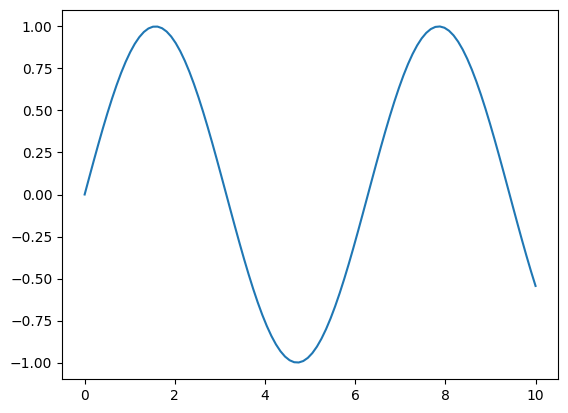

In [24]:

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
plt.plot(x, np.sin(x))
plt.show()


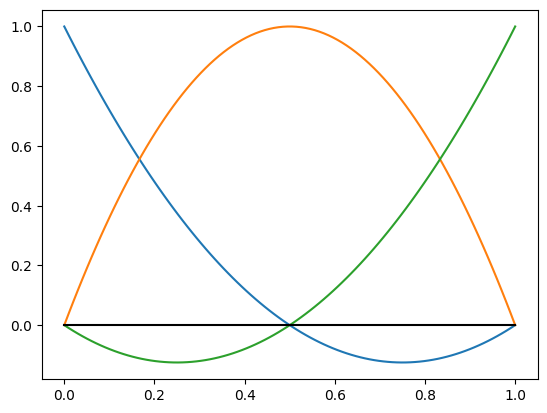

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)
x1 = 0
x2 = 0.5
x3 = 1
phi1 = (x - x2)/(x1 - x2) * ((x - x3)/(x1 - x3))
phi2 = (x - x1)/(x2 - x1) * ((x - x3)/(x2 - x3))
phi3 = (x - x1)/(x3 - x1) * ((x - x2)/(x3 - x2))


plt.plot(x, phi1)
plt.plot(x, phi2)
plt.plot(x, phi3)
plt.plot(x, [0 for _ in range(len(x))], color = 'black')